In [ ]:
#Install all the required dependencies if working on local environment
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import get_file
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow as imshow
from tensorflow.keras.layers import MaxPooling2D, Dense,Flatten , Conv2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
import pickle
from copy import copy
import os
from tensorflow.keras.models import load_model

# **Working on Input Files**
I will be taking symbols from the [Handwritten digits and Symbols](https://www.kaggle.com/datasets/clarencezhao/handwritten-math-symbol-dataset) and Numbers only from  [MNIST](https://www.kaggle.com/competitions/digit-recognizer/data)


In [ ]:
! gdown --id 1yAmvxHFg7BHO0oQlUxlw9p4dYyZs8lRT -O archive.zip
! gdown --id 1JmEDeIgqh-shEmIopgtaycpYeK_Kp3yT -O train.csv

In [ ]:
# deleting numbers and other files from Handwritten digit and symbols dataset
! unzip archive.zip
! cd /content/train/
! rm -r /content/train/decimal /content/train/equal /content/train/'other number' /content/train/'other sign' /content/train/'original number' /content/train/'original sign' /content/train/one /content/train/two /content/train/three /content/train/four /content/train/five /content/train/six /content/train/seven /content/train/eight /content/train/nine /content/train/zero
! mv -u /content/train/'plus cleaned' /content/train/10
! mv -u /content/train/minus /content/train/11
! mv -u /content/train/times /content/train/12
! mv -u /content/train/div /content/train/13

Streaming output truncated to the last 5000 lines.
  inflating: train/four/59106.jpg    
  inflating: train/four/5912.jpg     
  inflating: train/four/59135.jpg    
  inflating: train/four/59719.jpg    
  inflating: train/four/59777.jpg    
  inflating: train/four/59800.jpg    
  inflating: train/four/59827.jpg    
  inflating: train/four/59841.jpg    
  inflating: train/four/59915.jpg    
  inflating: train/four/59978.jpg    
  inflating: train/four/60008.jpg    
  inflating: train/four/60022.jpg    
  inflating: train/four/60487.jpg    
  inflating: train/four/60585.jpg    
  inflating: train/four/60817.jpg    
  inflating: train/four/61039.jpg    
  inflating: train/four/61356.jpg    
  inflating: train/four/61694.jpg    
  inflating: train/four/61771.jpg    
  inflating: train/four/61782.jpg    
  inflating: train/four/61927.jpg    
  inflating: train/four/6217.jpg     
  inflating: train/four/62194.jpg    
  inflating: train/four/62564.jpg    
  inflating: train/four/62697.jpg    

In [ ]:
#Here, Number of symbols is very less in dataset is very less in comparison to MNIST.
#so it must be repeated to not have a biased dataset

path = '/content/train'
symbols_dataset = image_dataset_from_directory(path ,color_mode = 'grayscale', image_size = (28,28),label_mode = 'int', batch_size = 32)
labels = symbols_dataset.class_names
print(labels) # labels give to ('+' , '-', '*' , '/')

# To convert Images having white features on black background(useful for feature detection)
symbols_dataset = symbols_dataset.map(lambda images, label : (255 - images, label  +10))


symbols_dataset = symbols_dataset.shuffle(3, reshuffle_each_iteration=True)
symbols_dataset = symbols_dataset.repeat(10)

Found 2193 files belonging to 4 classes.
['10', '11', '12', '13']


In [ ]:
mnist = pd.read_csv('train.csv')
mnist_labels = mnist['label'].to_numpy()

mnist_labels = mnist_labels.astype(np.int32)
print(mnist.columns)
mnist_labels.shape

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


(42000,)

In [ ]:
mnist.drop(columns = ['label'], inplace = True )


## **Peeking at Images from datasets**


690


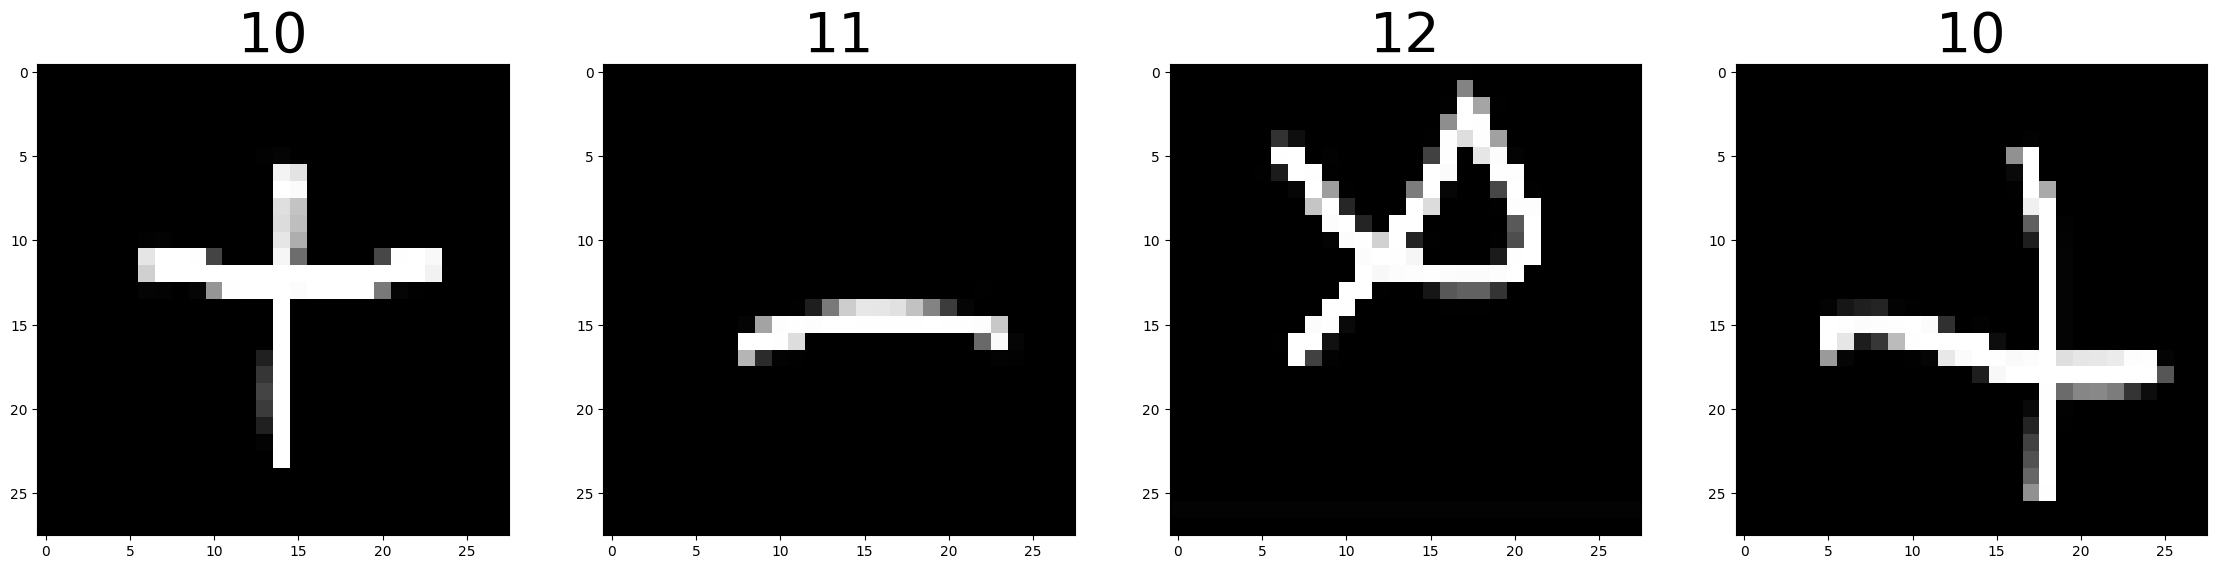

In [ ]:
# Symbols dataset
iter = symbols_dataset.as_numpy_iterator()
print(len(symbols_dataset)) # gives the number of batches of size 32 in dataset
batch = iter.next()


imshow(batch[0][0])


fig, ax = plt.subplots(ncols =4, figsize=(28,28))
i = 0
for  img in batch[0][:4]:
    ax[i].imshow(img.astype(int), cmap = 'gray')
    ax[i].title.set_text(batch[1][i])
    ax[i].title.set_size(40)
    i+=1

1313


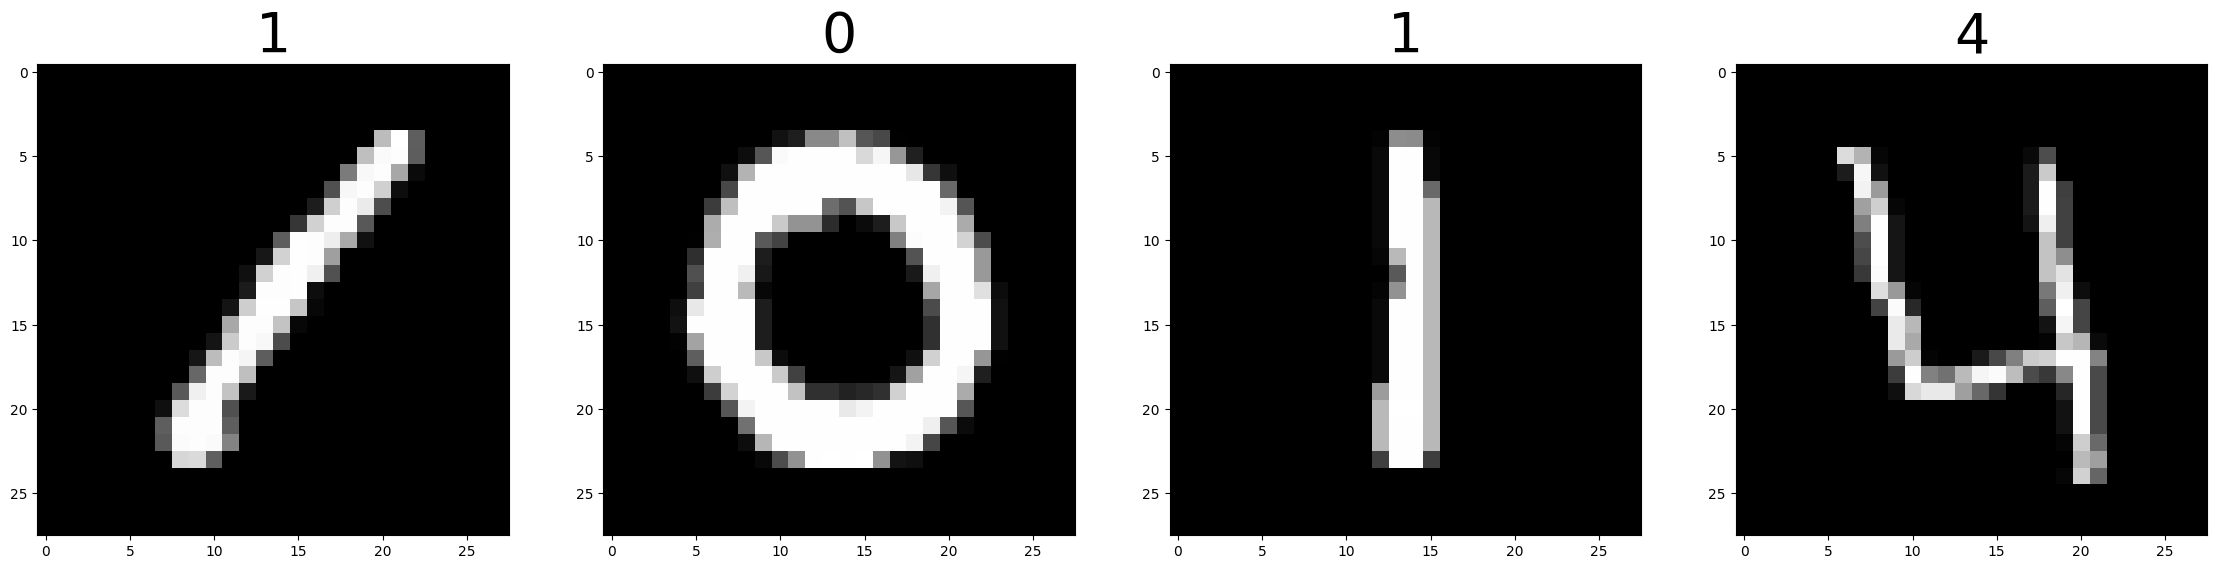

In [ ]:
mnist_train = mnist.to_numpy()
mnist_train = np.float32(mnist_train) # to make it compatible to symbols dataset

mnist_train = mnist_train.reshape(42000, 28,28)
imshow(mnist_train[0])

mnist_train = np.array([np.expand_dims(img, -1) for img in mnist_train])

fig, ax = plt.subplots(ncols =4, figsize=(28,28))

for  i in range(4):
    ax[i].imshow(mnist_train[i], cmap = 'gray')
    ax[i].title.set_text(mnist_labels[i])
    ax[i].title.set_size(40)

mnist_train.shape

#Generating the Number dataset
mnist_dataset = tf.data.Dataset.from_tensor_slices((mnist_train, mnist_labels)).batch(32)
print(len(mnist_dataset)) # prints the number of batches of size 32 in dataset

In [ ]:
dataset = symbols_dataset.concatenate(mnist_dataset)


dataset = dataset.shuffle(2000, reshuffle_each_iteration=False)

size1 = int(len(dataset) * 0.65)
size2 = int(len(dataset) * 0.25)
size3 =  len(dataset) - size1 - size2
print(dataset)
print(len(dataset))
train = dataset.take(size1)
val = dataset.skip(size1).take(size2)
test = dataset.skip(size1).skip(size2).take(size3)


<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
2003


# **Creating the model**

In [ ]:
class Solver:
  def __init__(self):
    self.model = Sequential()
    self.create()

  def create(self):
    self.model.add(Conv2D(50, (3, 3),  input_shape=(28, 28, 1), activation="relu"))
    self.model.add(MaxPooling2D(pool_size=(2, 2)))
    self.model.add(Conv2D(64, (3, 3), activation="relu"))
    self.model.add(MaxPooling2D(pool_size=(2, 2))) # maxpooling will take highest value from a filter of 2*2 shape

    # it will prevent overfitting
    self.model.add(Dropout(0.25))
    self.model.add(Conv2D(100, (3, 3),  activation="relu", padding = 'same')) # padding same ensures size doesn't change
    self.model.add(MaxPooling2D(pool_size=(2, 2)))
    self.model.add(Dropout(0.25))

    self.model.add(Flatten())
    self.model.add(Dense(128, activation="relu"))
    self.model.add(Dense(64, activation="relu"))

    self.model.add(Dropout(0.5))
    self.model.add(Dense(14, activation="softmax")) # 14 filters in final layer for 14 classes

  def compile(self):
    self.model.compile( loss=tf.losses.SparseCategoricalCrossentropy(),optimizer="adam",metrics=['accuracy'])
    return self.model.summary()

  def train(self, train, val, epoch_count, log = 'logs'):
    logs = tf.keras.callbacks.TensorBoard(log_dir=log) # to give summary plots
    result = self.model.fit(train, epochs= epoch_count, validation_data= val, callbacks=[logs])
    return result

  def test(self, test):
    result = self.model.evaluate(test)
    print("The Cost Function of the model returns:" ,result[0])
    print("The Accuracy of the model is:" , result[1])

  def save(self, name):
    self.model.save(os.path.join(name))


In [ ]:
model = Solver()
model.compile()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 26, 26, 50)        500       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 13, 13, 50)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 11, 11, 64)        28864     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 5, 5, 64)          0         
                                                                 
 conv2d_45 (Conv2D)          (None, 5, 5, 100)       

# **Model Training**

In [ ]:
result = model.train(train, val, 15)

Epoch 1/15
1301/1301 [==============================] - 105s 76ms/step - loss: 1.0926 - accuracy: 0.6913 - val_loss: 0.1540 - val_accuracy: 0.9567
Epoch 2/15
1301/1301 [==============================] - 94s 70ms/step - loss: 0.2646 - accuracy: 0.9275 - val_loss: 0.0687 - val_accuracy: 0.9815
Epoch 3/15
1301/1301 [==============================] - 99s 74ms/step - loss: 0.1728 - accuracy: 0.9551 - val_loss: 0.0810 - val_accuracy: 0.9794
Epoch 4/15
1301/1301 [==============================] - 99s 74ms/step - loss: 0.1450 - accuracy: 0.9634 - val_loss: 0.0504 - val_accuracy: 0.9859
Epoch 5/15
1301/1301 [==============================] - 91s 67ms/step - loss: 0.1245 - accuracy: 0.9681 - val_loss: 0.0571 - val_accuracy: 0.9850
Epoch 6/15
1301/1301 [==============================] - 101s 74ms/step - loss: 0.1040 - accuracy: 0.9728 - val_loss: 0.0477 - val_accuracy: 0.9887
Epoch 7/15
1301/1301 [==============================] - 91s 67ms/step - loss: 0.1050 - accuracy: 0.9739 - val_loss: 0.0365

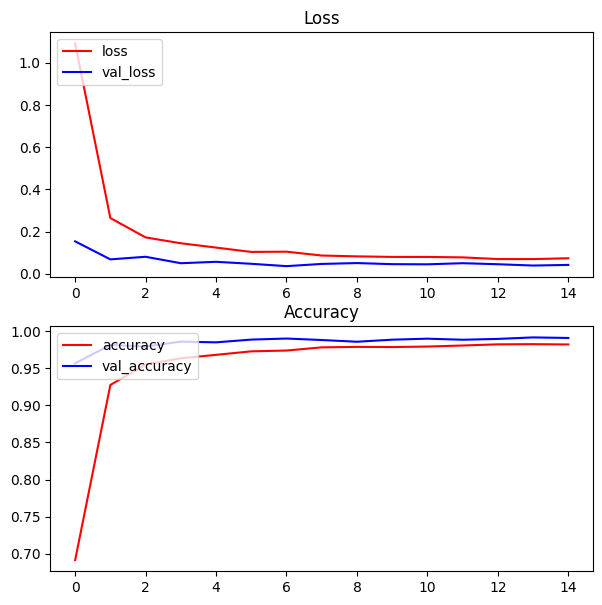

In [ ]:
fig,ax = plt.subplots( 2 , figsize = (7,7))

#Loss
ax[0].plot(result.history['loss'], color='red', label='loss')
ax[0].plot(result.history['val_loss'], color='blue',label='val_loss')
ax[0].set_title('Loss')
ax[0].legend(loc="upper left")

#Accuracy
ax[1].plot(result.history['accuracy'], color='red', label='accuracy')
ax[1].plot(result.history['val_accuracy'], color='blue', label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend(loc="upper left")
plt.show()

# **Model Testing**

In [ ]:
model.test(test)

202/202 [==============================] - 11s 32ms/step - loss: 0.0402 - accuracy: 0.9898
The Cost Function of the model returns: 0.04024425148963928
The Accuracy of the model is: 0.9897658824920654


In [ ]:
# Saving the Model
model.save('numclass.h5')

# **Making Predictions with the model**


In [ ]:
def process( image):
    img  =cv.imread(image)
    img = cv.resize(img, (800, 500) , interpolation = cv.INTER_LINEAR)
    for i in range(3):
      img = cv.erode(img, kernel = (6,6) )
    for i in range(2):
      img = cv.dilate(img, kernel = (6,6) )


    gray = cv.cvtColor(img , cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (0,0), sigmaX=33, sigmaY=33)
    gray = cv.divide(gray, blur, scale=255)

    ret, gray = cv.threshold(gray, 50, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU )
    contours, _ = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    rectangles = []
    image_copy = copy(gray)
    # imshow(gray)
    for contour in contours:
        x, y, w, h = cv.boundingRect(contour)
        if w*h > 50:
          cv.rectangle(image_copy, (x-10, y-20), (x+w+10, y+h+20), 255, 1)
          rectangles.append((x -10, y-20, x +w+10, y + h+20))
    rectangles = sorted(rectangles)

    # Selecting the Division symbol carefully using bitwise or of multiple images

    switc = 0
    i = 0

    new_rectangles = []
    while i + 2 < len(rectangles):
      rect1 = rectangles[i]
      rect2 = rectangles[i+1]
      rect3 = rectangles[i+2]
      if(rect2[0] < rect1[2] and rect2[0] > rect1[0] and rect3[0] < rect1[2] and rect3[0] > rect1[0] ):
        new_rectangles.append((min(rect1[0] , rect2[0] , rect3[0]) , min(rect1[1], rect2[1] , rect3[1]) , max(rect1[2] , rect2[2] , rect3[2]) , max(rect1[3], rect2[3] , rect3[3])))
        i+=3
      else:
        new_rectangles.append(rectangles[i])
        i+=1

    while i!= len(rectangles):
        new_rectangles.append(rectangles[i])
        i+=1

    rectangles = copy(new_rectangles)
    new_images =[gray[ x+1:z,w+1: y ] for (w,x,y,z) in rectangles]
    for i in range(len(new_images)):
      try:
        new_images[i] = cv.resize(new_images[i] , (28,28) , interpolation = cv.INTER_AREA)
      except:
        return "Image could not be processed"


    return new_images



In [ ]:
def solve(image):
    images = process(image)
    labels =  {x:f'{x}' for x in range(10)}
    labels[10] = '+'
    labels[11] = '-'
    labels[12] = '*'
    labels[13] = '/'
    if(type(images) == str) :
        return  images, [],[]
    predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
    result = mod.predict(predict_ds)
    predictions = np.argmax(result, axis = 1)
    predictions = [labels[pre] for pre in predictions]
    equation = ''.join(predictions)

    solve = 0
    try:
      solve = eval(equation)
      solve = f'{equation} = {solve}'
    except:
      solve = f"Predicted Equation [ {equation} ] is not a Valid Mathematical expression"
    return solve,images,predictions

In [ ]:
def evaluate(image):
  image1 = cv.imread(image)

  imshow(image1)
  ans,images, labels = solve(image)
  if(len(images)!=0):
    fig,ax =  plt.subplots(ncols = len(images) , figsize =(28,28))
    for i in range(len(images)):
       ax[i].imshow(images[i],cmap = 'gray')
       ax[i].title.set_text(f'Predicted Label: { labels[i]}')
       ax[i].title.set_size(12)

  print(ans)

In [ ]:
! gdown --id 1axhzu34Dv6mwPCGk8-1OX90noNsMuYa6 -O numclass.h5
mod = load_model('numclass.h5')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1axhzu34Dv6mwPCGk8-1OX90noNsMuYa6
To: /content/numclass.h5
100% 1.83M/1.83M [00:00<00:00, 38.8MB/s]


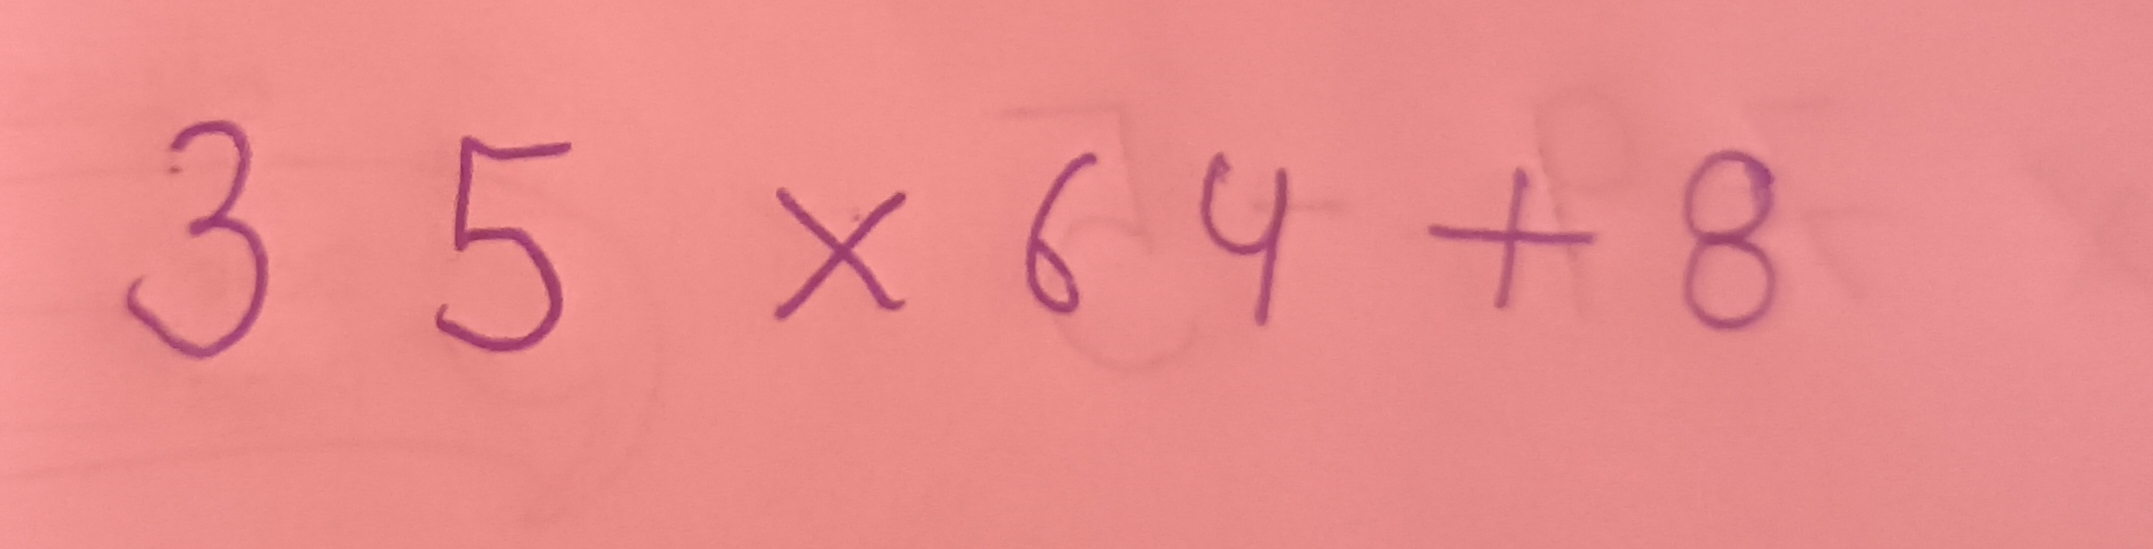

1/1 [==============================] - 0s 274ms/step
35*64+8 = 2248


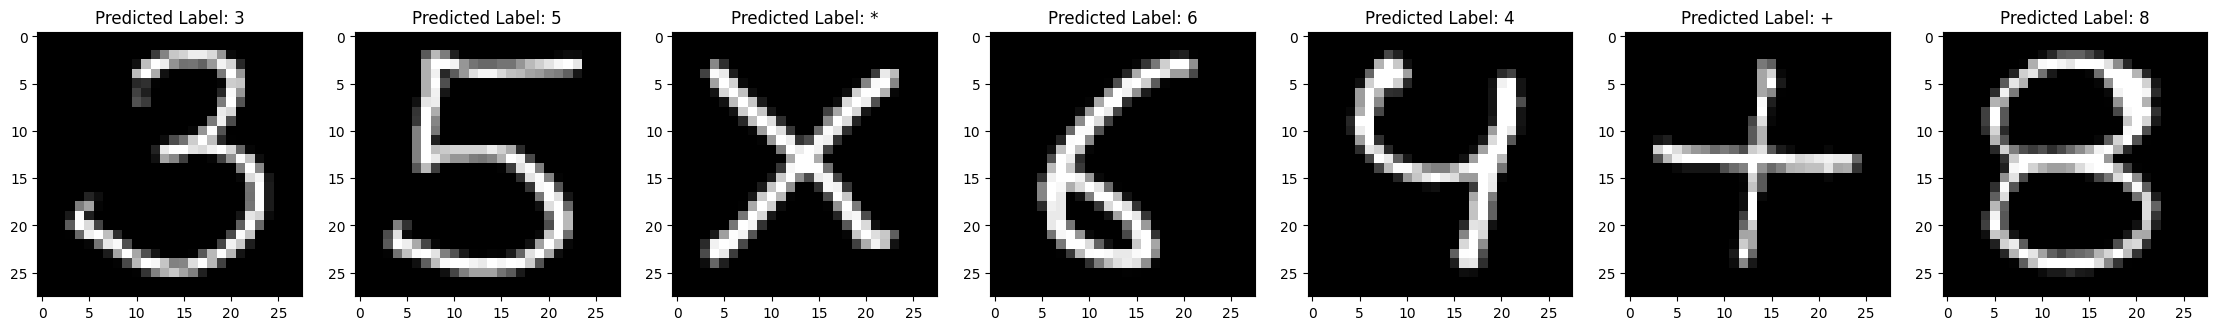

In [ ]:
image = 'please.jpg'
evaluate(image)

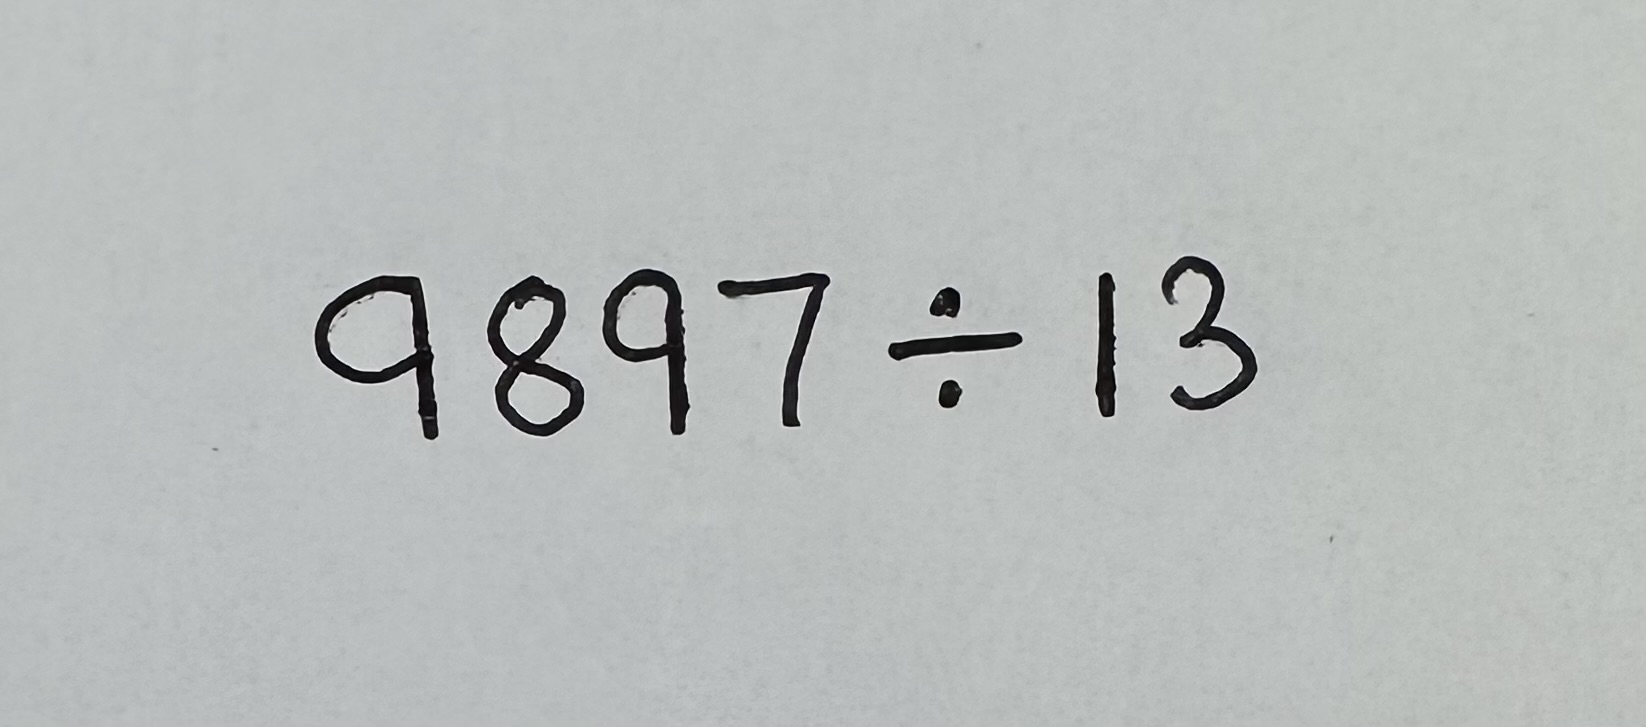

1/1 [==============================] - 0s 21ms/step
9897/13 = 761.3076923076923


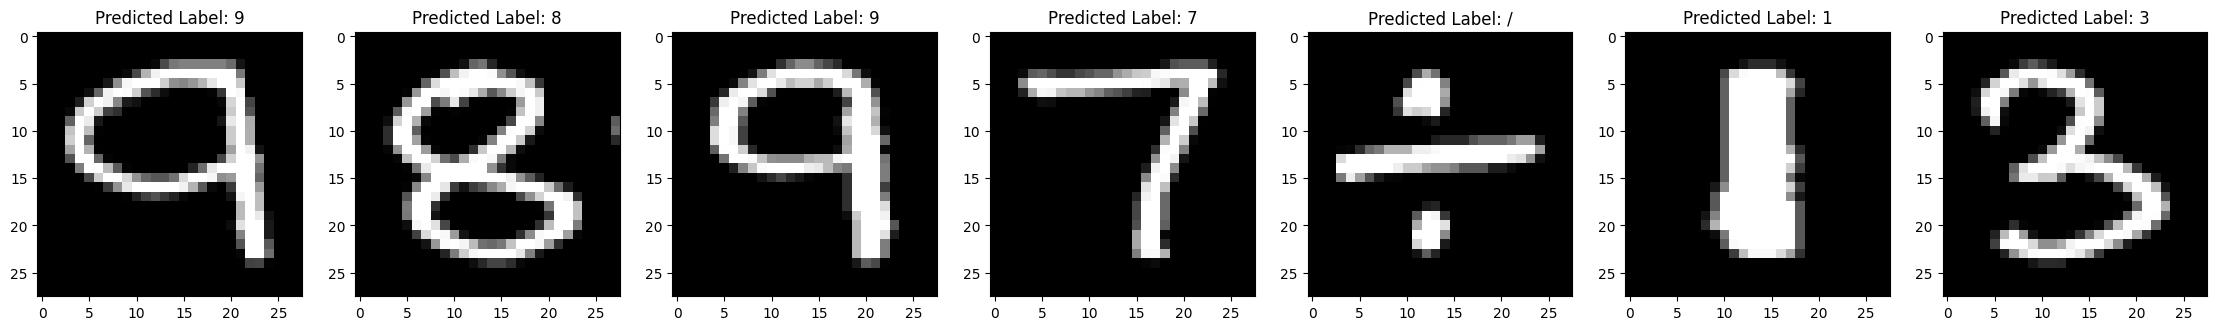

In [ ]:
image = 'IMG-1165.jpg'
evaluate(image)

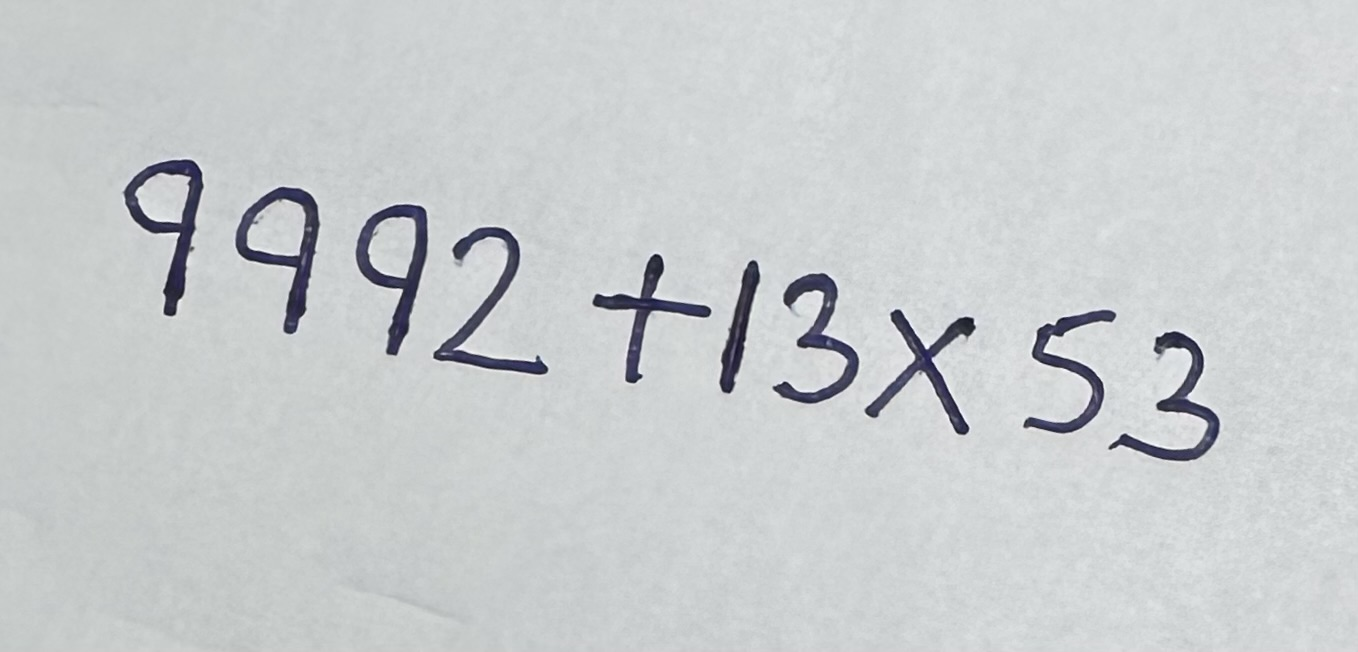

1/1 [==============================] - 0s 13ms/step
9992+13*53 = 10681


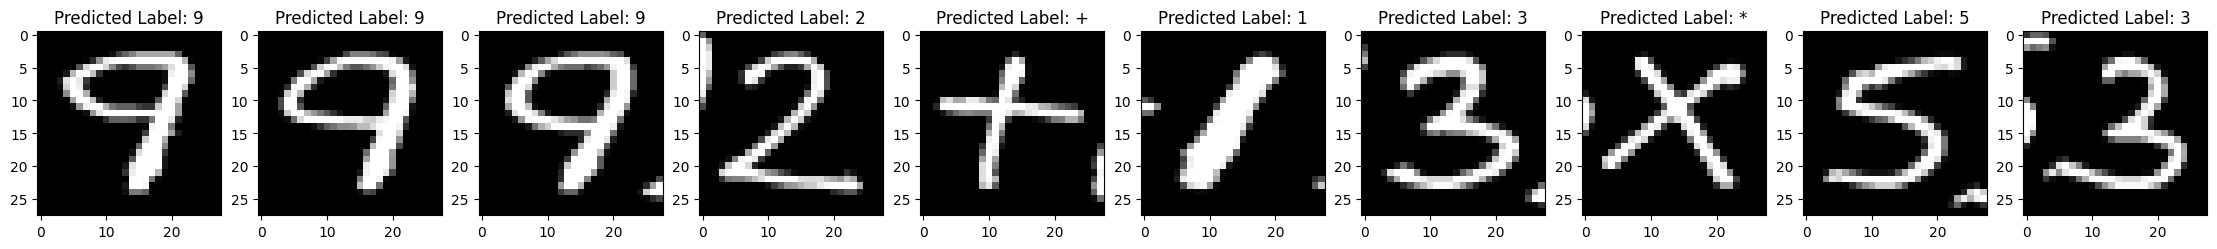

In [ ]:
image = 'IMG-1164.jpg'
evaluate(image)

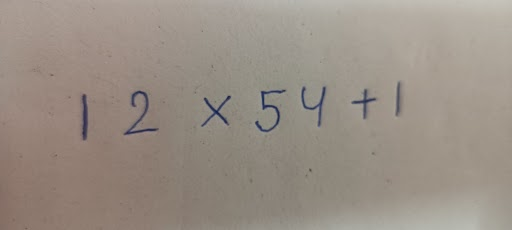

1/1 [==============================] - 0s 17ms/step
12*54+1 = 649


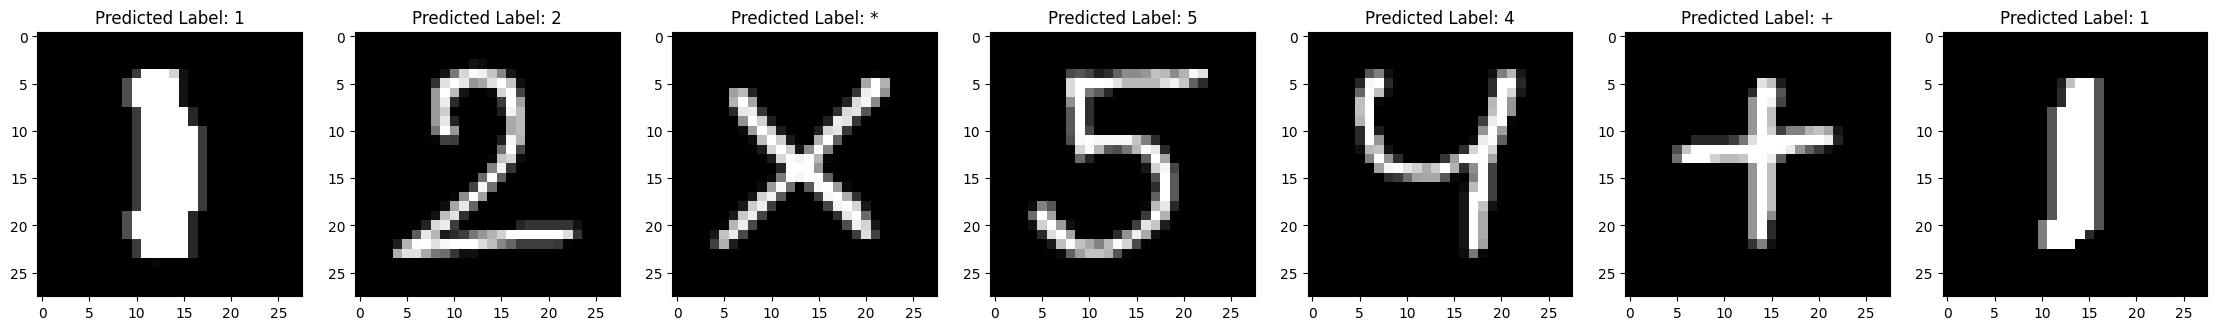

In [ ]:
image = 'unnamed.jpg'
evaluate(image)

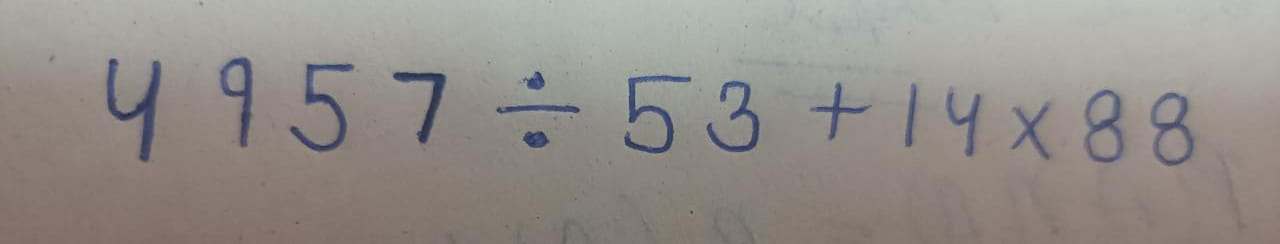

1/1 [==============================] - 0s 10ms/step
4957/53+14*88 = 1325.5283018867924


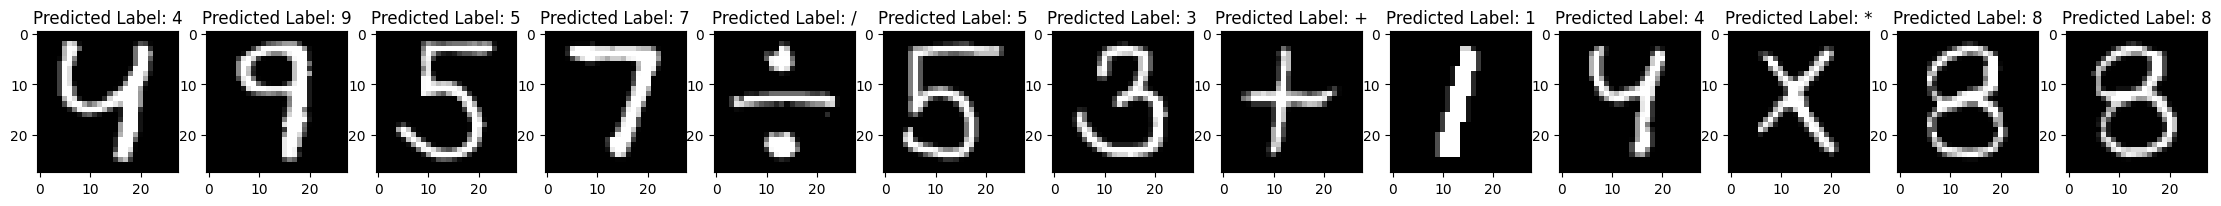

In [ ]:
image = 'more.jpeg'
evaluate(image)